# INF265 - Weeks 14-15: LSTM-based character level language models
Jakub Ryšavý

## Introduction

### Overview
In this assignment, we aim to design a simple character level language model in order to be able to generate new text similar to the text trained on during the
learning stage. More specifically and as implied by the name, character level language models operate at the level of characters (as opposed to words): given a fixed length sequence of characters, these models are trained to guess what
could be the next character. Owing to the sequential nature of the task, these models pair well with the so-called recurrent neural networks, a class of neural networks able to process sequential input by updating their internal state. Of particular interest are LSTMs (acronym for long short-term memory), a category of recurrent neural networks designed around the notion of ”gates” in order to better control the gradient flow and to mitigate the vanishing of the gradient
problem. In that sense, the connection between LSTMs and recurrent neural networks is comparable to that between residual networks and traditional feed-forward networks.

**In a nutshell, the main goal of this assignment will be for you to learn how to set up a whole pipeline with limited guidance in order to solve a natural language processing task.**

### Useful resources
- Stanford lecture on RNNs: https://youtu.be/6niqTuYFZLQ
- Project Gutemberg: https://www.gutenberg.org/

## Exercise


In [2]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm, trange
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter


### 1. Download a text document that you like.
The project Gutemberg is a good place to obtain legally interesting books!

In [3]:
!wget https://www.gutenberg.org/files/64317/64317-0.txt -O Great_Gatsby.txt
# !wget https://www.gutenberg.org/files/1342/1342-0.txt -O PrideAndPrejudice.txt
!ls

--2021-05-01 14:03:06--  https://www.gutenberg.org/files/64317/64317-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306258 (299K) [text/plain]
Saving to: ‘Great_Gatsby.txt’

Great_Gatsby.txt    100%[===================>] 299.08K  1.08MB/s    in 0.3s    

2021-05-01 14:03:07 (1.08 MB/s) - ‘Great_Gatsby.txt’ saved [306258/306258]

Great_Gatsby.txt  __notebook_source__.ipynb


### 2. Load and clean up the text.
You will 
- remove all accents, 
- force all letters to be lower case, 
- remove all occurrences of ”\n”, ”\t” and ”\r” 
- and make sure every two consecutive words in the text are separated by a single space ” ”. 
- You can also remove part (or all) of the punctuation.

In [4]:
import re
import unicodedata

def remove_accents(input_str):
    '''Source: https://stackoverflow.com/a/517974'''
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [57]:
def preprocess(text, verbose=True):
    l = len(text)
    # remove accents
    text = remove_accents(text)

    # lower case
    text = text.lower()

    # remove ”\n”, ”\t” and ”\r” 
    text = re.sub(r"[\ufeff\n\t\s]+", ' ', text)

    # verify word separation by single space
    # text = re.sub(r"[\s]+", ' ', text)
    text = ' '.join(text.split()) + ' '

    # remove punctuation
    text = re.sub(r"[;:,]+", '', text) # TODO: try to remove ','

    # MY APPROACH
    # remove numbers
    text = re.sub(r"[0123456789]+", '', text)

    # replace short forms (contractions) with full form
    text = re.sub(r"it’s", "it is", text)
    text = re.sub(r"i’ll", "i will", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"i’v", "i have", text)
    text = re.sub(r"i’d", "i had", text) # this is not correct for all the cases, but this is more offten
    text = re.sub(r"we’ve", "we have", text)
    text = re.sub(r"we’re", "we are", text)

    # remove special characters 
    text = re.sub(r"[#\[\](){}}\*&@$€%—\-\\/'\"““”«»„“»«‘’`’_]+", '', text)

    if verbose:
        removed = l-len(text)
        if removed != 0:
            print(f"{removed} characters was removed during preprocessing.")
    return text

###################################################

book = ""
filename = 'Great_Gatsby.txt'
# filename = 'PrideAndPrejudice.txt'
num_lines = sum(1 for line in open(filename,'r'))
# print(f"\nThe book {filename[:-4]} has {num_lines} lines.")

with open(filename) as f:
    for line in tqdm(f, total=num_lines):
    # for line, i in zip(f, range(500)):
        if len(line) <= 1:
            continue
        book = book + preprocess(line, verbose=False)
        # print(line, end='')

print("###################")
book[10000:11000]

  0%|          | 0/6773 [00:00<?, ?it/s]

###################


'tfully wherever people played polo and were rich together. this was a permanent move said daisy over the telephone but i didnt believe iti had no sight into daisys heart but i felt that tom would drift on forever seeking a little wistfully for the dramatic turbulence of some irrecoverable football game. and so it happened that on a warm windy evening i drove over to east egg to see two old friends whom i scarcely knew at all. their house was even more elaborate than i expected a cheerful redandwhite georgian colonial mansion overlooking the bay. the lawn started at the beach and ran towards the front door for a quarter of a mile jumping over sundials and brick walks and burning gardensfinally when it reached the house drifting up the side in bright vines as though from the momentum of its run. the front was broken by a line of french windows glowing now with reflected gold and wide open to the warm windy afternoon and tom buchanan in riding clothes was standing with his legs apart on 

In [6]:
# book = "test!"

### 3. Create a character-based vocabulary from the preprocessed text: 
Every appearing character will have a unique integer ID. You can use a dictionary structure to store the vocabulary.

In [7]:
vocabulary = {}
alphabet = set(book)
vocabulary = dict((i, c) for i, c in enumerate(sorted(alphabet)))
vocabulary_rev = dict((c, i) for i, c in vocabulary.items())
vocab_size = len(vocabulary)
print(vocab_size)
print(vocabulary.items())
print(vocabulary_rev.items())

30
dict_items([(0, ' '), (1, '!'), (2, '.'), (3, '?'), (4, 'a'), (5, 'b'), (6, 'c'), (7, 'd'), (8, 'e'), (9, 'f'), (10, 'g'), (11, 'h'), (12, 'i'), (13, 'j'), (14, 'k'), (15, 'l'), (16, 'm'), (17, 'n'), (18, 'o'), (19, 'p'), (20, 'q'), (21, 'r'), (22, 's'), (23, 't'), (24, 'u'), (25, 'v'), (26, 'w'), (27, 'x'), (28, 'y'), (29, 'z')])
dict_items([(' ', 0), ('!', 1), ('.', 2), ('?', 3), ('a', 4), ('b', 5), ('c', 6), ('d', 7), ('e', 8), ('f', 9), ('g', 10), ('h', 11), ('i', 12), ('j', 13), ('k', 14), ('l', 15), ('m', 16), ('n', 17), ('o', 18), ('p', 19), ('q', 20), ('r', 21), ('s', 22), ('t', 23), ('u', 24), ('v', 25), ('w', 26), ('x', 27), ('y', 28), ('z', 29)])


### 4. Generate the data $(X, y)$ for a character level language model:
a) Decide of a sequence length $L$.

b) For every sub-sequence formed from $L + 1$ consecutive characters in
your text (with stride 1):

- i. Convert every character from that sub-sequence into its corresponding integer ID.

- ii. Convert the $L$ first integer IDs into one-hot vectors (whose size will be equal to the size of the vocabulary) and store them in the
features matrix $X$.

- iii. Store the last integer ID in the labels vector $y$ (remember that in pytorch, labels do not need to be one-hot encoded).



Assuming $N$ is the number of such sub-sequences and $S$ is the size of the vocabulary, the above procedure should yield two tensors $X$ and
y of respective shape $(N, L, S)$ and $(N, )$.

Let us illustrate this with a toy example. We consider the following text: ”test!”. The vocabulary is {0: ”!”, 1: ”e”, 2: ”s”, 3: ”t”} thus $S = 4$. We choose to fix the sequence length to $L = 3$, which results in $N = 2$ sub-sequences [”t”, ”e”, ”s”, ”t”] and [”e”, ”s”, ”t”, ”!”]. The data would therefore be $(X, y)$ as returned by the following procedure:

[image]

**Hint:** Extracting the sub-sequences can be done efficiently using the `torch.nn.functional.unfold()` method. The one-hot encoding can be vectorized as well, using the `torch.scatter()` method in order to fill a zeros tensor.

I implemented this two times, because I missed the hint first.

In [8]:
L = 20

# Old uneffective implementation
def one_hot_encode(l):
    encoded = []
    for i, number in enumerate(l):
        zeros = [0]*vocab_size
        zeros[number] = 1
        encoded.append(zeros)
    return encoded

def extract_and_encode_OLD(L=L, book=book):
    X = []
    y = []
    for i in range(len(book)- (L)):
        subseq = book[i:i+L+1]
        '''Source: https://stackoverflow.com/a/13149770'''
        indexes = [list(vocabulary.keys())[list(vocabulary.values()).index(c)] for c in subseq]
        x = one_hot_encode(indexes[:-1])
        y.append(indexes[-1])
        X.append(x)

    X = torch.Tensor(X)
    y = torch.Tensor(y).type(torch.LongTensor)
    dataset = TensorDataset(X, y)
    print(f"X.size = {X.size()}, y.size={y.size()}")
    return dataset
extract_and_encode_OLD()

X.size = torch.Size([277320, 10, 30]), y.size=torch.Size([277320])


In [9]:
def extract_and_encode(L=L, book=book, verbose=False):
    indexes = torch.LongTensor([vocabulary_rev[char] for char in book])
    unfolded = indexes.unfold(0, L+1, 1)
    y = unfolded[:, -1] #.long()
    X = torch.nn.functional.one_hot(unfolded[:, :-1], num_classes=vocab_size).float()
    if verbose:
        print(f"X.size = {X.size()}, y.size={y.size()}")
    dataset = TensorDataset(X, y)
    return dataset

dataset = extract_and_encode(verbose=True)
dataset

X.size = torch.Size([277320, 10, 30]), y.size=torch.Size([277320])


### 5. Shuffle then split the data between train and validation sets.
You probably want to keep most of the data available for training.

In [48]:
def shuffle_and_split(dataset=dataset, batch_size=4096):
    train_len = int(0.8 * dataset.__len__())
    val_len = dataset.__len__() - train_len
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_len, val_len])

    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
    val_dl = DataLoader(val_ds, shuffle=True, batch_size=batch_size)
    return train_dl, val_dl

train_dl, val_dl = shuffle_and_split()

### 6. Implement a LSTM classifier designed to predict the next character from a sequence of $L$ consecutive characters.
A good starting point would be to stack a `torch.nn.LSTM()` module followed by a `torch.nn.Linear()` layer.

**Hint:** For this task, we need a ”many-to-one” type of LSTM.

In [29]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=vocab_size, hidden_dim=32, layer_dim=2, output_dim=vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

LSTMClassifier()

LSTMClassifier(
  (rnn): LSTM(30, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=30, bias=True)
  (softmax): Softmax(dim=1)
)

### 7. Implement the training loop.
You will choose carefully the loss function and a metric that are suitable for the task. Your code will print the loss and the chosen metric at the end of every epoch, both for the train and
the validation sets.

In [12]:
y = [y for (_,y) in dataset]
number_of_classes = Counter([int(yy) for yy in y])
print(number_of_classes.most_common())

[(0, 51378), (8, 27004), (23, 20357), (4, 18203), (18, 17244), (12, 15381), (17, 15257), (22, 13449), (11, 13197), (21, 12571), (7, 10446), (15, 8741), (24, 6357), (16, 5871), (26, 5774), (10, 5324), (6, 5168), (28, 4894), (9, 4589), (19, 3494), (2, 3490), (5, 3476), (14, 2104), (25, 2022), (13, 437), (3, 328), (27, 319), (20, 171), (29, 149), (1, 125)]


As we can see in the plot below, the classes (numbers of character occurences) are very **inbalanced**.
I decided to calculate _weight_ of the classes and use it for the _loss_ calculation.

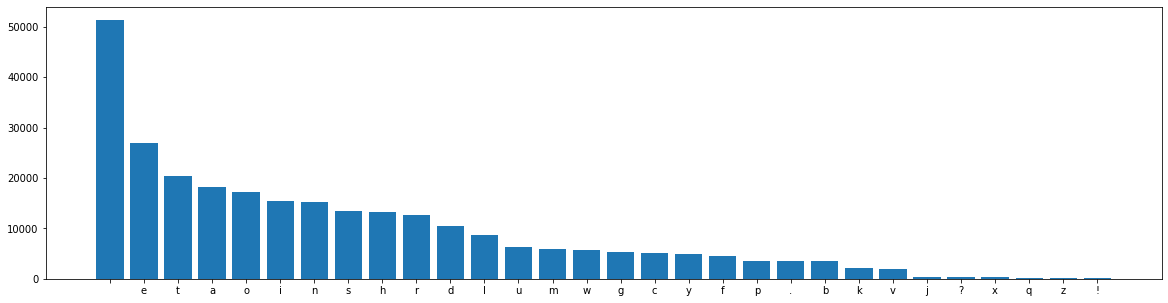

In [13]:
plt.figure(figsize=(20, 5))
plt.bar(x=[vocabulary[k] for (k,_) in number_of_classes.most_common()],
        height=[v for (_,v) in number_of_classes.most_common()])
plt.show()

In [14]:
# I tried to improve learning by using class weights, but it does not really help.
class_sample_count = np.unique(y, return_counts=True)[1]
# print(class_sample_count)
weight = 1. / class_sample_count
# weight = class_sample_count / sum(class_sample_count) # my test - does not improve
# samples_weight = weight[y]
# samples_weight = torch.from_numpy(samples_weight)
# samples_weight
weight = torch.from_numpy(weight).float()
weight

tensor([0.1853, 0.0005, 0.0126, 0.0012, 0.0656, 0.0125, 0.0186, 0.0377, 0.0974,
        0.0165, 0.0192, 0.0476, 0.0555, 0.0016, 0.0076, 0.0315, 0.0212, 0.0550,
        0.0622, 0.0126, 0.0006, 0.0453, 0.0485, 0.0734, 0.0229, 0.0073, 0.0208,
        0.0012, 0.0176, 0.0005])

In [15]:
!pip install torchmetrics
from torchmetrics import Accuracy, Precision, MetricCollection

In [49]:
n_epochs = 420

model = LSTMClassifier()
model = LSTMClassifier(hidden_dim=32, layer_dim=2)
# iterations_per_epoch = len(train_dl)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

def train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl):
    best_acc = 0
    best_prec = 0
    best_epoch = 0
    patience, trials = 42, 0
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Actual device:", device)
    criterion = torch.nn.NLLLoss()
#     criterion = torch.nn.NLLLoss(weight=weight.to(device))
    # opt = torch.optim.RMSprop(model.parameters())#, lr=lr)
    opt = torch.optim.Adam(model.parameters()) #, lr=lr)
    model.to(device)    

    print('Start model training')

    for epoch in trange(1, n_epochs + 1):
        metrics = MetricCollection([
            Accuracy(),
            Precision(num_classes=vocab_size, average='macro'),
            # Precision(),
            ]).to(device)
        metrics.reset()
        val_metrics = MetricCollection([
            Accuracy(),
            Precision(num_classes=vocab_size, average='macro'),
            # Precision(),
            ]).to(device)
        val_metrics.reset()
        for i, (x_batch, y_batch) in enumerate(train_dl):
            model.train()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # sched.step()
            opt.zero_grad()
            out = model(x_batch)
            loss = criterion(torch.log(out), y_batch)
            loss.backward()
            opt.step()

            preds = out.argmax(dim=1)
            # calculate train metrics
            metrics.update(preds, y_batch)
        
        model.eval()
        for x_val, y_val in val_dl:
            x_val, y_val = [t.to(device) for t in (x_val, y_val)]
            out = model(x_val)
            preds = out.argmax(dim=1)
            val_loss = criterion(torch.log(out), y_val)
            val_metrics.update(preds, y_val)

        res = metrics.compute()
        val_res = val_metrics.compute()
        print(f'''Epoch: {epoch:3d}. 
    TrainLoss: {loss.item():.4f}, TrainAcc.: {res["Accuracy"]:2.2%}, TrainPrecission {res["Precision"]:2.2%}
    ValidLoss: {val_loss.item():.4f}, ValidAcc.: {val_res["Accuracy"]:2.2%}, ValidPrecission {val_res["Precision"]:2.2%}''')
            # print(res)

        if val_res["Accuracy"].item() > best_acc:
            trials = 0
            best_acc = val_res["Accuracy"].item()
            best_prec = val_res["Precision"].item()
            best_epoch = epoch
            torch.save(model.state_dict(), 'best.pth')
            print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
        else:
            trials += 1
            if trials >= patience:
                print(f'Early stopping on epoch {epoch}')
                break
    return best_epoch, best_acc, best_prec

train_model(n_epochs=1)
# train_model()

Actual device: cuda:0
Start model training


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.9361, TrainAcc.: 16.38%, TrainPrecission 0.97%
    ValidLoss: 2.8749, ValidAcc.: 18.68%, ValidPrecission 0.62%
Epoch 1 best model saved with accuracy: 18.68%
Epoch:   2. 
    TrainLoss: 2.9082, TrainAcc.: 18.49%, TrainPrecission 0.62%
    ValidLoss: 2.8873, ValidAcc.: 18.68%, ValidPrecission 0.62%
Epoch:   3. 
    TrainLoss: 2.9021, TrainAcc.: 18.49%, TrainPrecission 0.62%
    ValidLoss: 2.8582, ValidAcc.: 18.68%, ValidPrecission 0.62%
Epoch:   4. 
    TrainLoss: 2.8541, TrainAcc.: 18.49%, TrainPrecission 0.62%
    ValidLoss: 2.8268, ValidAcc.: 18.68%, ValidPrecission 0.62%
Epoch:   5. 
    TrainLoss: 2.8140, TrainAcc.: 20.50%, TrainPrecission 1.39%
    ValidLoss: 2.7280, ValidAcc.: 22.37%, ValidPrecission 1.37%
Epoch 5 best model saved with accuracy: 22.37%
Epoch:   6. 
    TrainLoss: 2.6951, TrainAcc.: 22.89%, TrainPrecission 1.41%
    ValidLoss: 2.6330, ValidAcc.: 23.33%, ValidPrecission 1.43%
Epoch 6 best model saved with accuracy: 23.33%
Epoch:   7. 


(10, 0.30649814009666443, 0.07952532172203064)

In [17]:
# res = metrics.compute()
# print(res)
# print(f"Accuracy: {res['Accuracy']}")
# res['Accuracy'].item()

### 8. Finetune your model 
(for simplicity, no model selection pipeline required in this exercise): you will play with the hyperparameters of your model,
including (non-exclusively) the sequence length, the hidden size of the LSTM module, the number of layers in the LSTM module, the batch size and the weight decay.

In [ ]:
Ls = [5, 15, 20]
hidden_sizes = [16, 32, 64] # higher for overfitt
n_layers = [1, 2, 3]
# batch_size = [4096] # I think, it does not involve training. But I realized that it influence the speed
# weight_decay = ...

#### Optimization of $layer\_dim$

In [ ]:
n_epochs = 100
hidden_size = 32
n = 1
results = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
# for hidden_size in hidden_sizes:
for n in tqdm(n_layers):
    print(n)
    model = LSTMClassifier(hidden_dim=hidden_size, layer_dim=n)
    res = train_model(n_epochs=n_epochs, model=model)
    # res = model_training(n_epochs=n_epochs, model=model)
    results = results.append(
        pd.Series(
            [f"layer_dim={n}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results

I realized, that **one** layer of LSTM is sufficient. Using more layers slightly increase the performance; however, training is much slower.

#### Optimization of $hidden\_size$

In [ ]:
n_epochs = 100
n = 2
results = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
for hidden_size in tqdm(hidden_sizes):
    print(hidden_size)
    model = LSTMClassifier(hidden_dim=hidden_size, layer_dim=n)
    res = train_model(n_epochs=n_epochs, model=model)
    # res = model_training(n_epochs=n_epochs, model=model)
    results = results.append(
        pd.Series(
            [f"hidden_size={hidden_size}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results

For $hidden\_size=64$ we can see that model easily overfit, because the size of vocabulary is smaller.

For final model, $hidden\_size=32$ was chosen, because it should be sufficient for the vocabulary.

#### Optimize $L$

In [18]:
n_epochs = 100
n = 2
Ls = [5, 15, 20]
results = pd.DataFrame(columns=["Parameters", "Best epoch", "Accuracy", "Precision"])
for L in tqdm(Ls):
    print(L)
    dataset = extract_and_encode(L, book)
    train_dl, val_dl = shuffle_and_split(dataset)
    model = LSTMClassifier(hidden_dim=32, layer_dim=1)
    res = train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl)
    results = results.append(
        pd.Series(
            [f"L={L}", *res],
            index=["Parameters", "Best epoch", "Accuracy", "Precision"]
        ), ignore_index=True
    )
results

  0%|          | 0/5 [00:00<?, ?it/s]

1
Actual device: cuda:0
Start model training


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.4554, TrainAcc.: 23.10%, TrainPrecission 5.52%
    ValidLoss: 2.3629, ValidAcc.: 27.56%, ValidPrecission 5.51%
Epoch 1 best model saved with accuracy: 27.56%
Epoch:   2. 
    TrainLoss: 2.3207, TrainAcc.: 27.31%, TrainPrecission 6.48%
    ValidLoss: 2.4227, ValidAcc.: 27.56%, ValidPrecission 6.49%
Epoch:   3. 
    TrainLoss: 2.3407, TrainAcc.: 27.30%, TrainPrecission 6.48%
    ValidLoss: 2.2838, ValidAcc.: 27.56%, ValidPrecission 6.49%
Epoch:   4. 
    TrainLoss: 2.4137, TrainAcc.: 27.29%, TrainPrecission 6.45%
    ValidLoss: 2.2281, ValidAcc.: 27.56%, ValidPrecission 6.49%
Epoch:   5. 
    TrainLoss: 2.3454, TrainAcc.: 27.28%, TrainPrecission 6.47%
    ValidLoss: 2.3678, ValidAcc.: 27.57%, ValidPrecission 6.49%
Epoch 5 best model saved with accuracy: 27.57%
Epoch:   6. 
    TrainLoss: 2.4198, TrainAcc.: 27.28%, TrainPrecission 6.43%
    ValidLoss: 2.2917, ValidAcc.: 27.58%, ValidPrecission 6.50%
Epoch 6 best model saved with accuracy: 27.58%
Epoch:   7. 


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.2958, TrainAcc.: 25.15%, TrainPrecission 10.02%
    ValidLoss: 2.3375, ValidAcc.: 32.16%, ValidPrecission 11.53%
Epoch 1 best model saved with accuracy: 32.16%
Epoch:   2. 
    TrainLoss: 2.0017, TrainAcc.: 34.06%, TrainPrecission 20.75%
    ValidLoss: 2.2514, ValidAcc.: 36.30%, ValidPrecission 19.54%
Epoch 2 best model saved with accuracy: 36.30%
Epoch:   3. 
    TrainLoss: 1.9420, TrainAcc.: 37.29%, TrainPrecission 24.47%
    ValidLoss: 1.9694, ValidAcc.: 38.59%, ValidPrecission 25.34%
Epoch 3 best model saved with accuracy: 38.59%
Epoch:   4. 
    TrainLoss: 1.9924, TrainAcc.: 39.37%, TrainPrecission 25.67%
    ValidLoss: 2.0399, ValidAcc.: 39.93%, ValidPrecission 26.02%
Epoch 4 best model saved with accuracy: 39.93%
Epoch:   5. 
    TrainLoss: 2.0576, TrainAcc.: 40.35%, TrainPrecission 27.81%
    ValidLoss: 2.2012, ValidAcc.: 40.75%, ValidPrecission 26.77%
Epoch 5 best model saved with accuracy: 40.75%
Epoch:   6. 
    TrainLoss: 1.9664, TrainAcc.: 41.

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.2551, TrainAcc.: 25.15%, TrainPrecission 7.47%
    ValidLoss: 2.3473, ValidAcc.: 30.65%, ValidPrecission 8.98%
Epoch 1 best model saved with accuracy: 30.65%
Epoch:   2. 
    TrainLoss: 2.1810, TrainAcc.: 33.08%, TrainPrecission 19.37%
    ValidLoss: 2.1205, ValidAcc.: 35.07%, ValidPrecission 16.05%
Epoch 2 best model saved with accuracy: 35.07%
Epoch:   3. 
    TrainLoss: 2.1312, TrainAcc.: 36.36%, TrainPrecission 21.17%
    ValidLoss: 2.0285, ValidAcc.: 37.28%, ValidPrecission 22.11%
Epoch 3 best model saved with accuracy: 37.28%
Epoch:   4. 
    TrainLoss: 2.1736, TrainAcc.: 38.18%, TrainPrecission 23.27%
    ValidLoss: 2.1248, ValidAcc.: 38.92%, ValidPrecission 22.63%
Epoch 4 best model saved with accuracy: 38.92%
Epoch:   5. 
    TrainLoss: 2.1636, TrainAcc.: 39.72%, TrainPrecission 24.97%
    ValidLoss: 1.9890, ValidAcc.: 39.72%, ValidPrecission 25.82%
Epoch 5 best model saved with accuracy: 39.72%
Epoch:   6. 
    TrainLoss: 1.8568, TrainAcc.: 40.67

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.3094, TrainAcc.: 24.13%, TrainPrecission 6.19%
    ValidLoss: 2.3693, ValidAcc.: 30.95%, ValidPrecission 9.16%
Epoch 1 best model saved with accuracy: 30.95%
Epoch:   2. 
    TrainLoss: 2.0775, TrainAcc.: 32.63%, TrainPrecission 18.08%
    ValidLoss: 2.2325, ValidAcc.: 34.32%, ValidPrecission 20.47%
Epoch 2 best model saved with accuracy: 34.32%
Epoch:   3. 
    TrainLoss: 2.1178, TrainAcc.: 35.06%, TrainPrecission 20.92%
    ValidLoss: 2.2768, ValidAcc.: 36.39%, ValidPrecission 20.61%
Epoch 3 best model saved with accuracy: 36.39%
Epoch:   4. 
    TrainLoss: 2.1246, TrainAcc.: 36.80%, TrainPrecission 23.45%
    ValidLoss: 2.1455, ValidAcc.: 37.64%, ValidPrecission 24.35%
Epoch 4 best model saved with accuracy: 37.64%
Epoch:   5. 
    TrainLoss: 1.9461, TrainAcc.: 38.52%, TrainPrecission 24.24%
    ValidLoss: 2.1043, ValidAcc.: 39.47%, ValidPrecission 25.19%
Epoch 5 best model saved with accuracy: 39.47%
Epoch:   6. 
    TrainLoss: 1.9862, TrainAcc.: 40.22

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.4335, TrainAcc.: 22.03%, TrainPrecission 5.95%
    ValidLoss: 2.3454, ValidAcc.: 29.26%, ValidPrecission 6.81%
Epoch 1 best model saved with accuracy: 29.26%
Epoch:   2. 
    TrainLoss: 2.3812, TrainAcc.: 30.95%, TrainPrecission 11.23%
    ValidLoss: 2.2552, ValidAcc.: 32.09%, ValidPrecission 10.34%
Epoch 2 best model saved with accuracy: 32.09%
Epoch:   3. 
    TrainLoss: 2.2012, TrainAcc.: 33.36%, TrainPrecission 18.51%
    ValidLoss: 2.2650, ValidAcc.: 34.34%, ValidPrecission 18.10%
Epoch 3 best model saved with accuracy: 34.34%
Epoch:   4. 
    TrainLoss: 2.0748, TrainAcc.: 35.27%, TrainPrecission 20.54%
    ValidLoss: 2.0921, ValidAcc.: 36.12%, ValidPrecission 20.16%
Epoch 4 best model saved with accuracy: 36.12%
Epoch:   5. 
    TrainLoss: 2.1756, TrainAcc.: 36.81%, TrainPrecission 21.07%
    ValidLoss: 2.0394, ValidAcc.: 37.23%, ValidPrecission 20.54%
Epoch 5 best model saved with accuracy: 37.23%
Epoch:   6. 
    TrainLoss: 2.2251, TrainAcc.: 38.02

,Parameters,Best epoch,Accuracy,Precision
0,L=1,12,0.276115,0.065242
1,L=3,99,0.482295,0.421417
2,L=5,97,0.507077,0.445590
3,L=10,97,0.505301,0.442147
4,L=15,100,0.500694,0.411537


During optimization of $L$ (window/sequence size) the RAM limit was reached (for $L=40$).
Theoreticaly, longerhigher $L$ could be better; however, it is hard for LSTM to deal with long sequences.

Finaly, $L=30$ was chosen.


From my view, I think the $batch\_size$ does not influence learning performance.

### 9. Train your model and analyze its performance.

In [30]:
L = 20
n_epochs = 420
hidden_dim = 32

dataset = extract_and_encode(L, book)
train_dl, val_dl = shuffle_and_split(dataset)
model = LSTMClassifier(hidden_dim=hidden_dim, layer_dim=2)
train_model(n_epochs=n_epochs, model=model, train_dl=train_dl, val_dl=val_dl)

Actual device: cuda:0
Start model training


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch:   1. 
    TrainLoss: 2.5237, TrainAcc.: 20.70%, TrainPrecission 5.66%
    ValidLoss: 2.5732, ValidAcc.: 28.24%, ValidPrecission 7.33%
Epoch 1 best model saved with accuracy: 28.24%
Epoch:   2. 
    TrainLoss: 2.2836, TrainAcc.: 29.86%, TrainPrecission 9.85%
    ValidLoss: 2.2429, ValidAcc.: 31.14%, ValidPrecission 8.86%
Epoch 2 best model saved with accuracy: 31.14%
Epoch:   3. 
    TrainLoss: 2.0478, TrainAcc.: 32.02%, TrainPrecission 12.73%
    ValidLoss: 2.0186, ValidAcc.: 34.01%, ValidPrecission 15.63%
Epoch 3 best model saved with accuracy: 34.01%
Epoch:   4. 
    TrainLoss: 2.0636, TrainAcc.: 34.28%, TrainPrecission 18.45%
    ValidLoss: 2.1496, ValidAcc.: 36.17%, ValidPrecission 17.94%
Epoch 4 best model saved with accuracy: 36.17%
Epoch:   5. 
    TrainLoss: 2.2006, TrainAcc.: 36.20%, TrainPrecission 21.29%
    ValidLoss: 1.9617, ValidAcc.: 38.07%, ValidPrecission 25.03%
Epoch 5 best model saved with accuracy: 38.07%
Epoch:   6. 
    TrainLoss: 2.0702, TrainAcc.: 37.60%,

(406, 0.5356280207633972, 0.48106953501701355)

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model2 = LSTMClassifier().to(device)
# model2 = LSTMClassifier(hidden_dim=32, layer_dim=1).to(device)
model2.load_state_dict(torch.load('best.pth'))
print(model2)

LSTMClassifier(
  (rnn): LSTM(30, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=30, bias=True)
  (softmax): Softmax(dim=1)
)


### 10. Use your trained model to generate new text:
- (a) Choose a ”seed sequence” consisting of $L$ characters of your choice (among the characters in the vocabulary).
- (b) Encode the seed sequence the same way you encoded X in Question
4 (in this case, $N = 1$).
- (c) Pass your encoded seed sequence through your trained model.
- (d) Predict the next character as the argmax of the softmax activation on the output.
- (e) One-hot encode the predicted character.
- (f) Update the seed sequence: remove the encoded character in first position of the encoded seed sequence, then add the encoded predicted character in last position of the encoded seed sequence.
- (g) Repeat (c)-(f).

In [32]:
seed_seq = ""
seed_seq = "update the seed sequence remove the encoded character in first position of the encoded seed sequence"[:L]
while len(seed_seq) != L:
    seed_seq = input(f"Enter the seed sequence of lenght {L}.\n")

print(seed_seq)

update the seed sequ


In [33]:
def encode_sequence(seq):
    indexes = [list(vocabulary.keys())[list(vocabulary.values()).index(c)] for c in seq]
    return torch.Tensor(one_hot_encode(indexes))

# len(encode_sequence("!.0"))
encoded = encode_sequence(seed_seq)
encoded.size()

torch.Size([20, 30])

In [34]:
steps = 10
out_string = ""
for _ in range(steps):
    for _ in range(100):
        # out = model(encoded.unsqueeze(0).to(device))
        out = model2(encoded.unsqueeze(0).to(device))
        new_char = vocabulary[out.argmax(dim=1).item()]
        print(new_char, end='')
        out_string = out_string + new_char
        encoded = torch.cat((encoded[1:], encode_sequence(new_char)), dim=0)
    print()

print('\n', set(out_string))

ert of the same the forther and the stared and the sathered and the rook and the could the started t
o the state and the contine and the start and the complained and the said the could the moved and th
e car and the contore and the way and the could the car and the content of the sat the foundation an
d the state on the stare and the could the start and the complet and the corner and the same the man
 in the moment of the started and the could the start and the could the start and the start and the 
start and the coloun and the cours and the corners and the more the could to the start and the sat a
nd the content and the same and the seemed when i was a remarted and the started and the countrinur 
of the state of the stange and the could and the completery and the some and the continted to the sa
id the state and the said the soather and the could tom to the start and the sening the corners and 
the marked and the conderst of the contore and the state and the contear to the started the

In [35]:
print(set(out_string))

{'w', 'd', 'k', 'g', 'r', 'm', 'a', 'i', 'e', 'c', 't', 'h', ' ', 's', 'y', 'f', 'n', 'o', 'u', 'l', 'v', 'p'}


### 11. What problem seems to occur with the previous procedure ?

It predict the same all the time. There is not enough diversity. Number of uniquely predicted characters is not sufficient.

### 12. Modify the procedure described in Question 10: 
Rather than predicting the next character as the argmax of the softmax activation on the output,
you will instead sample it from the probability distribution given by the softmax activation on the output.

In [50]:
raw_book = ""
with open(filename) as f:
    for line in tqdm(f, total=num_lines):
    # for line, i in zip(f, range(500)):
        if len(line) <= 1:
            continue
        raw_book = raw_book + line

capital_words = []
for i in range(len(raw_book)):
    if raw_book[i].isupper():
        if raw_book[i:i+2] == "I " or raw_book[i:i+3] in  ["I, ", "I’m", "I’d", "I’v", "I’l"]:
            continue
        for j in range(2,10):
            if raw_book[i:i+j].lower() not in raw_book:
                capital_words.append(raw_book[i:i+j])
                continue
capital_words = list(set(capital_words))

len(capital_words)

  0%|          | 0/6773 [00:00<?, ?it/s]

12084

In [56]:
def posprocess(text):
    for punctuation in ['.', '?', '!']:
        # text = '. '.join([sentence.capitalize() for sentence in text.split('. ')])
        text = f'{punctuation} '.join([sentence[0].upper()+sentence[1:] for sentence in text.split(f'{punctuation} ')])
    text = re.sub(r" i ", " I ", text)
    text = re.sub(r" +", " ", text)
    text = re.sub(r"gatsb", "Gatsb", text)
    for word in capital_words:
        regex = re.escape(word.lower())
        text = re.sub(regex, word, text)
    return text

def generate_text(characters=1_000, model=model2, init=''):
    ''' 
    characters: number of generated characters
    init: sequence for initialization
    '''
    while len(init) != L:
        init = input(f"Enter the seed sequence of lenght {L}.\n").lower()
        if len(init) > L:
            answer = input("Do you want to trim the input to the desired length? Type \'y\':").lower()
            if answer in ["y", "yes", "ok"]:
                init = init[:L]
    encoded = encode_sequence(init)
    text = init
    for _ in trange(characters):
        out = model(encoded.unsqueeze(0).to(device))
        new_char = np.random.choice(np.array(list(vocabulary.values()), dtype=object), 
                             p=out[0].cpu().detach().numpy())
        text += new_char
        encoded = torch.cat((encoded[1:], encode_sequence(new_char)), dim=0)
    text = posprocess(text)
    return text

generate_text(init='hello how hello how ') 
# Hello how 

  0%|          | 0/1000 [00:00<?, ?it/s]

'Hello how hello how copiet for the liness plow. Me are back sat on churshes arm a clial dlunkous projent stopples and for came The frine cams unfity laughedndent holding! Make to oh here in. Treear nculted was as going rugmirs overlontaatantly the rini. An hapn from chandlo as hand Tom? Eyost acod intermalty much an agat the yloon garde livicered room we tout qeacting pracmom of way in letabhilly into get of the suesbedny car best wild way atfysucain he sourement of their expuse a battlomstessitciod bukemic to mills flatiar. Ye olver basyy. He loing of most of everyboly around handone a longitt is just blunt are. He went in the are very and with from in licktre oborm as then tip wound Baker I saw Tom in fress of exctan reptae tHe bele smokingued sopyond young Gatsby So you whish. The room place to Why into the yeap worf floor of eassry said Jordan at my hand. Me grainglo nems use Amen in yes windy faint and her neynt like reary or my macker. I wallbelve his after her I triyrounday him

### 13. Entertain us by generating amusing text !
:-)

In [54]:
generate_text(init='hello how are you? i')

  0%|          | 0/1000 [00:00<?, ?it/s]

'Hello how are you? I someblive peri. The crusanthen the shoust bichoure intuicutal octon houny white becare to see said and picksish enchicy when was you eftainixgy ney me suster she went of his said and the carebark impeddience combure off hal bute rise. I had Daisy. You was she rayh. He was feet of thit was call charely playhems of liner it wel enforiay and broke twrened shiveran on the wild She stantl turnering leest lessred me. Hitcel lotieufughdorebar oddordowily holdes moning to ladegin around of fyrwiforing south Mr. Dand buriselly. Call poscinged the next I dyiving. We excenes and out blooked wishoe patted mnenon the poding. Was in a stiptle mad was them was seas with the dont adment time or right. When He had in ris trisnight as the ylois mad too he Cun once bringiess knew we then sometoon himserden ac what with pritity I copeort it around bone astidhion lovely a armsons and liunrw in and mocer encha of a trung I stare brought a laughd Yor hadn libtisecas that a dlass aroundi

In [55]:
generate_text(init='gatsby and daisy are')

  0%|          | 0/1000 [00:00<?, ?it/s]

'Gatsby and Daisy are Gatsbys face Daisy work a like big one it faish lost or oncice wit thee Doncon the hayrecoston ladinge someone back. There amation a tameed the. The home af the traded in joat to lightessotinding hold you got hik it all very aglice tricged wrese I ore or herad. Im and tmuth rotexple OF DAMped defrottly ina onb ohze if it bloan. She fice creak we lude and there eyann hag any seem use now to daul out of one of to a overnongevera reseecivition doze in most knowe so house Tom he undighles. That Rosarve little garnast but her wonl ic a dlack and funny of air. Down or that coli And unDuted whiteme to say hand caperenvating and seell. Eaginide was assoleemy puche a mlied for a greielly perce. Or the Yorfoul book saw whisper times sweall contie cost rather made himserglioker. Foal Gatsby whener heu inforfuce one lintrired at off or spembly and him now makents firlectry rappate. Ive voieur ofazy of restensior? Into all with a sege I can and on too an any. Help a whisperiti

In [59]:
generate_text(init='some other random te')

  0%|          | 0/1000 [00:00<?, ?it/s]

'Some other random ten he fet to the sat cxapf har fully of two the moved qcoafred so going id him inkir at soal beaning youthe and Gatsby in a vativery campsaiting. A certair. Whytelsold in a cleld in to holdny. .old wannedy hern. And wat to eive mymonfiniced the laceman punding ubdiselybnence faruncer Mrs. Oxeuse. Shivang work Hot a parted asker to eporar painthy up lones and from jrintiathee burey companded to lange esCuneicatelizilecurate in my possian I thouel ogfombousled their hand of you Wilson is a previaring. We have he foone at surrded or hiswy you ot an an ord on theirs. And too I jere a sid of it to lighted the besamy by with. Facending some going and these agreees any young heirn. You? Ufninf gald upade and most litt the promisely mage at his weld slow brate said ccicagher sistrankarf waiter littlege swimsed in her inkied the perastion her a little oulo even criby an otge fells as bat ono thin oned a vasuich seveur of the can accousecoplenseled rision and him purling inte

You can test my generator with you own input! ;-)

In [38]:
# generate_text()